In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import warnings

In [48]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # Show full column names
warnings.filterwarnings('ignore')

In [49]:
df =pd.read_csv('Cleaned_hostel_dataset.csv')

In [50]:
df.head()

,gender,year_study,current_stay,preference,pref_reasons,pref_afford,pref_proximity,pref_social,pref_amenities,pref_security,change_accommodation,satisfaction,prefer_closer,distance_affects_attendance,commute_mode,commute_walk,commute_bike,commute_bus,commute_taxi,proximity_focus,funding_source,changed_before,less_pref_due_cost,amenities_list,amenity_water,amenity_electricity,amenity_internet,amenity_laundry,amenity_aircon,amenity_cleanbath,issues_basic_services,water_supply,electricity_supply,internet_access,room_cleanliness,bathroom_facility,hostel_management,study_space_conducive,env_collaboration,social_influence,rating,security_personnel,security_cctv,security_fencing,security_checkin,security_none,experienced_theft,security_confidence,focus_feeling,mental_health,consistent_study_routine,study_elsewhere,study_hours
0,Male,4,Off-Campus,Off-campus hostel,"Affordability Proximity to lecture halls Availability of amenities (Wi-Fi, water, etc.)",1,1,0,1,0,No,5,No,Not at all,Walking,1,0,0,0,3,Parents/Guardians,Yes,No,Water Electricity Internet Air conditioning/Fans Clean bathroom Facilities,1,1,1,0,1,1,Rarely,4,5,3,4,4,5,Yes,4,No,4,0,1,1,0,0,No,Very good,4,4,Yes,Yes,5
1,Male,4,Off-Campus,On-campus hostel,"Proximity to lecture halls Access to social life Availability of amenities (Wi-Fi, water, etc.) Security",0,1,1,1,1,Yes,3,No,Sometimes,Walking,1,0,0,0,4,Parents/Guardians,No,Yes,Water Electricity Internet Air conditioning/Fans Clean bathroom Facilities,1,1,1,0,1,1,Occasionally,4,3,2,3,2,3,No,2,Yes,4,0,0,1,0,0,Yes,Poor,3,3,Sometimes,Yes,3
2,Female,4,Off-Campus,Off-campus hostel,Affordability Access to social life,1,0,1,0,0,No,5,No,Sometimes,Walking,1,0,0,0,3,Parents/Guardians,Yes,No,Water Electricity Internet Clean bathroom Facilities,1,1,1,0,0,1,Rarely,4,5,3,5,5,4,Not available foruse,3,No,4,0,0,1,0,0,No,Excellent,5,4,Yes,No,3
3,Male,4,Off-Campus,Off-campus hostel,"Affordability Proximity to lecture halls Access to social life Availability of amenities (Wi-Fi, water, etc.) Security",1,1,1,1,1,Maybe,3,No,Not at all,Walking Shuttle/Bus,1,0,1,0,4,Parents/Guardians,Yes,No,Water Electricity Internet Clean bathroom Facilities,1,1,1,0,0,1,Occasionally,4,3,4,4,5,3,Yes,5,Yes,5,0,1,1,0,0,No,Very good,4,4,Yes,No,4
4,Female,4,Off-Campus,On-campus hostel,"Availability of amenities (Wi-Fi, water, etc.)",0,0,0,1,0,Yes,4,No,Sometimes,Walking,1,0,0,0,5,Parents/Guardians,No,Yes,Electricity,0,1,0,0,0,0,Frequently,3,5,3,2,1,1,Yes,5,Yes,5,0,0,0,0,1,Yes,Poor,3,3,Sometimes,No,3


In [51]:
# ===================== DATA PREP =====================
X = df.drop(columns=['current_stay','amenities_list','pref_reasons','commute_mode'])
y = df['current_stay']

# Encode target
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Identify categorical & numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns

# Preprocessor for sklearn models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ]
)

In [52]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5, stratify=y
)

# ===================== MODELS =====================
results = {}

# 1. Logistic Regression
log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(C= 0.00010252953819534085, solver= 'liblinear'))
])
log_reg.fit(X_train, y_train)
results['Logistic Regression'] = accuracy_score(y_test, log_reg.predict(X_test))

# 2. Random Forest
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=5, n_estimators= 109, max_depth= 6, min_samples_split= 8))
])
rf.fit(X_train, y_train)
results['Random Forest'] = accuracy_score(y_test, rf.predict(X_test))

# 3. SVC
svc = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(C= 0.2895147240684614, kernel= 'linear', gamma= 'scale'))
])
svc.fit(X_train, y_train)
results['SVC'] = accuracy_score(y_test, svc.predict(X_test))

# 4. LightGBM (with preprocessor)
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(early_stopping_rounds=100, n_estimators= 344, 
                        learning_rate= 0.010429368030066888, num_leaves= 123, 
                        max_depth= 3, subsample= 0.609419302989372, colsample_bytree= 0.5039350249768169,))
])

lgbm.fit(X_train, y_train,
         model__eval_set=[(preprocessor.transform(X_test), y_test)],
         model__eval_metric='logloss')

results['LightGBM'] = accuracy_score(y_test, lgbm.predict(X_test))

# 5. CatBoost (with preprocessor)
cat = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(verbose=0, iterations= 104, depth= 6, learning_rate= 0.11228099867162707, l2_leaf_reg= 6.752433664856421))
])
cat.fit(X_train, y_train)
results['CatBoost'] = accuracy_score(y_test, cat.predict(X_test))

# ===================== RESULTS =====================
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
display(results_df)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 144, number of negative: 176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 57
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits

,Model,Accuracy
4,CatBoost,0.9625
1,Random Forest,0.9500
3,LightGBM,0.9375
0,Logistic Regression,0.8750
2,SVC,0.8750


In [65]:
# Get feature names after one-hot encoding
ohe = log_reg.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numeric_cols, ohe_features])

# Coefficients
log_reg_importance = pd.Series(
    log_reg.named_steps['model'].coef_[0],  # First class
    index=all_features
).sort_values(ascending=False)

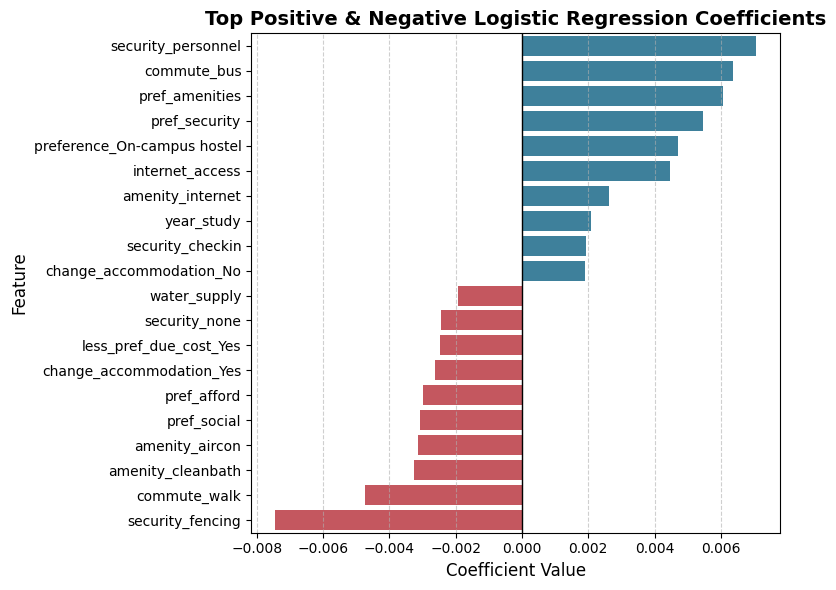

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get top 10 positive and top 10 negative coefficients
top_pos = log_reg_importance.head(10)
top_neg = log_reg_importance.tail(10)
top_features = pd.concat([top_pos, top_neg])

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x=top_features.values,
    y=top_features.index,
    palette=["#2E86AB" if v > 0 else "#D64550" for v in top_features.values]
)
plt.axvline(0, color='black', linewidth=1)
plt.title("Top Positive & Negative Logistic Regression Coefficients", fontsize=14, weight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


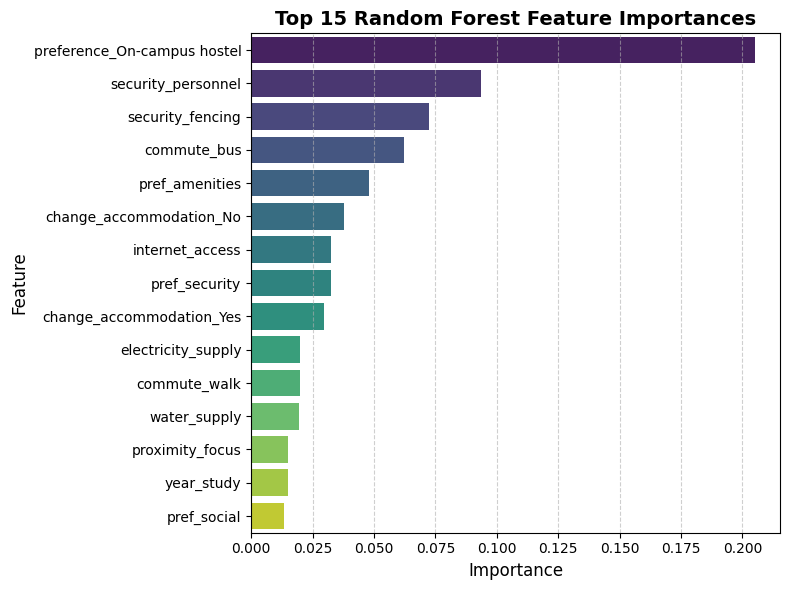

In [70]:
# Access Random Forest model from pipeline
rf_model = rf.named_steps['model']  # replace 'model' with your step name

# Get feature importances
rf_importance = pd.Series(
    rf_model.feature_importances_,
    index=all_features
).sort_values(ascending=False)

# Take top 15
top_features = rf_importance.head(15)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x=top_features.values,
    y=top_features.index,
    palette='viridis'
)
plt.title("Top 15 Random Forest Feature Importances", fontsize=14, weight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


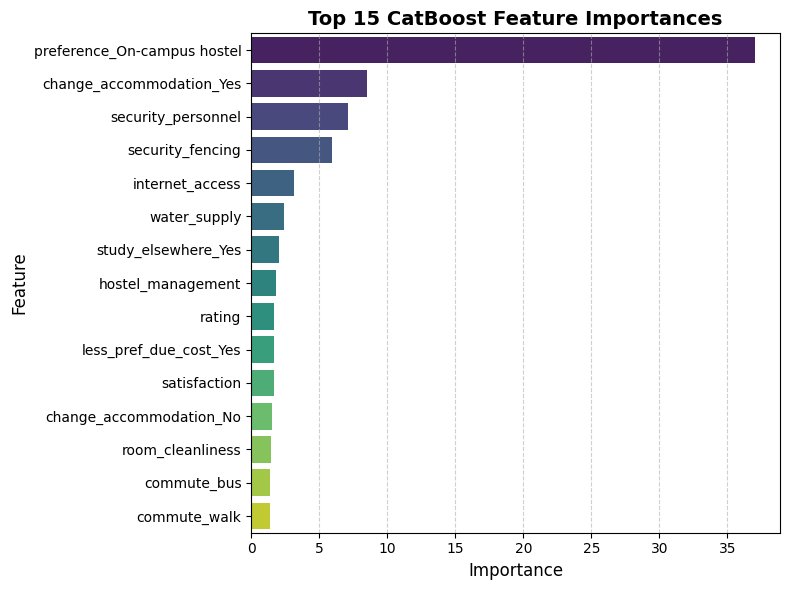

In [69]:
# Access CatBoost model inside pipeline
cat_model = cat.named_steps['model']  # replace 'model' with your step name

# Get feature importance
cb_importance = pd.Series(
    cat_model.get_feature_importance(),
    index=all_features
).sort_values(ascending=False)

# Plot top 15
top_features = cb_importance.head(15)

plt.figure(figsize=(8, 6))
sns.barplot(
    x=top_features.values,
    y=top_features.index,
    palette='viridis'
)
plt.title("Top 15 CatBoost Feature Importances", fontsize=14, weight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [57]:
# import optuna
# from optuna.samplers import TPESampler
# import warnings
# warnings.filterwarnings('ignore')

# # Common settings
# sampler = TPESampler(seed=5)
# n_trials = 500  # number of search iterations per model

# def tune_log_reg(trial):
#     C = trial.suggest_float("C", 0.0001, 100, log=True)
#     solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
#     model = Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', LogisticRegression(max_iter=200, C=C, solver=solver))
#     ])
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)
#     return accuracy_score(y_test, preds)

# def tune_rf(trial):
#     n_estimators = trial.suggest_int("n_estimators", 100, 500)
#     max_depth = trial.suggest_int("max_depth", 3, 20)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
#     model = Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', RandomForestClassifier(
#             n_estimators=n_estimators,
#             max_depth=max_depth,
#             min_samples_split=min_samples_split,
#             random_state=5
#         ))
#     ])
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)
#     return accuracy_score(y_test, preds)

# def tune_svc(trial):
#     C = trial.suggest_float("C", 0.1, 10, log=True)
#     kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
#     gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
#     model = Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', SVC(C=C, kernel=kernel, gamma=gamma))
#     ])
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)
#     return accuracy_score(y_test, preds)

# def tune_lgbm(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'random_state': 5
#     }
#     model = Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', lgb.LGBMClassifier(**params))
#     ])
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)
#     return accuracy_score(y_test, preds)

# def tune_catboost(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 500),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'random_state': 5,
#         'verbose': 0
#     }
#     model = Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', CatBoostClassifier(**params))
#     ])
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)
#     return accuracy_score(y_test, preds)


# # Run optimization for each model
# results = {}

# for name, func in [
#     ("Logistic Regression", tune_log_reg),
#     ("Random Forest", tune_rf),
#     ("SVC", tune_svc),
#     ("LightGBM", tune_lgbm),
#     ("CatBoost", tune_catboost)
# ]:
#     study = optuna.create_study(direction="maximize", sampler=sampler)
#     study.optimize(func, n_trials=n_trials)
#     results[name] = study.best_value
#     print(f"{name} best params: {study.best_params}")

# # Create results dataframe
# results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
# print(results_df)
